In [2]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline 


In [3]:
words = open('names.txt','r').read().splitlines() 


In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
#building the dataset 

g = torch.Generator().manual_seed(2147483647)

block_size = 3 #contxt length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] #crops and appends 

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
#new way of building the dataset 

def build_dataset(words):
    block_size = 3 #context length: how many characters do we take to predict the next one>
    X,Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y 

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
C = torch.randn((27,2), generator=g) #fitting 27 characters into two 
C

tensor([[ 1.5674, -0.2373],
        [-0.0274, -1.1008],
        [ 0.2859, -0.0296],
        [-1.5471,  0.6049],
        [ 0.0791,  0.9046],
        [-0.4713,  0.7868],
        [-0.3284, -0.4330],
        [ 1.3729,  2.9334],
        [ 1.5618, -1.6261],
        [ 0.6772, -0.8404],
        [ 0.9849, -0.1484],
        [-1.4795,  0.4483],
        [-0.0707,  2.4968],
        [ 2.4448, -0.6701],
        [-1.2199,  0.3031],
        [-1.0725,  0.7276],
        [ 0.0511,  1.3095],
        [-0.8022, -0.8504],
        [-1.8068,  1.2523],
        [ 0.1476, -1.0006],
        [-0.5030, -1.0660],
        [ 0.8480,  2.0275],
        [-0.1158, -1.2078],
        [-1.0406, -1.5367],
        [-0.5132,  0.2961],
        [-1.4904, -0.2838],
        [ 0.2569,  0.2130]])

In [9]:
C[5]

tensor([-0.4713,  0.7868])

In [10]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.4713,  0.7868])

In [11]:
#you can index with a list in python, also use tensors 
C[torch.tensor([5,6,7])]

tensor([[-0.4713,  0.7868],
        [-0.3284, -0.4330],
        [ 1.3729,  2.9334]])

In [12]:
#so we will index using X since it can take multidimensional tensors 
print(C[X][13,2])
print(X[13,2])

tensor([-0.0274, -1.1008])
tensor(1)


In [13]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [14]:
#creating the hidden layer 

W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g) 

In [15]:
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape

torch.Size([228146, 6])

In [16]:
torch.cat(torch.unbind(emb,1), 1).shape

torch.Size([228146, 6])

In [17]:
a = torch.arange(18)
a 


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [18]:
a.shape

torch.Size([18])

In [19]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [20]:
a.storage()

C:\Users\Neel\AppData\Local\Temp\ipykernel_31816\214256462.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [21]:
emb.view(emb.shape[0],6) == torch.cat(torch.unbind(emb,1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        ...,
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

In [22]:
h = torch.tanh(emb.view(emb.shape[0], 6))@W1 + b1

In [23]:
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)

In [24]:
logits = h @ W2 + b2

In [25]:
logits.shape

torch.Size([228146, 27])

In [26]:
counts = logits.exp()

In [27]:
prob = counts/counts.sum(1, keepdims=True)

In [28]:
prob.shape 

torch.Size([228146, 27])

In [29]:
#now we want to go through the prob tensor and pluck out the correct probability for the correct word in the y tensor that we want to predict 
prob[torch.arange(Y.shape[0]),Y]

tensor([4.0553e-23, 9.3123e-30, 1.1566e-34,  ..., 3.4113e-22, 2.8589e-13,
        8.5220e-08])

In [30]:
loss = -prob[torch.arange(Y.shape[0]),Y].log().mean() 
loss 

tensor(inf)

In [31]:
F.cross_entropy(logits, Y) #better version of calculating your own loss, more efficient backward pass

tensor(44.7215)

In [32]:
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn((200), generator=g)
W2 = torch.randn((200,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C, W1, b1, W2, b2] 

In [33]:

sum(p.nelement() for p in parameters) 

11897

In [34]:
for p in parameters:
    p.requires_grad = True 


In [35]:
lre = torch.linspace(-3,0,1000) 
lrs = 10**lre 

lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [36]:
lri = []
lossi=[] 

stepi = []

In [37]:


for i in range(50000):

    #minibatch construction: 
    ix = torch.randint(0,Xtr.shape[0], (32,))


    #forward pass 
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30)@W1+b1)
    logits = h@W2+b2 
    loss = F.cross_entropy(logits, Ytr[ix])

    #print(loss.item())

    

    #backward pass 
    for p in parameters: 
        p.grad = None 
    loss.backward()


    #update 
    lr = 0.1
    for p in parameters:
        p.data += -lr*p.grad 

    #track stats 
    # lri.append(lre[i])
    # lossi.append(loss.item())

    stepi.append(i)
    lossi.append(loss.log10().item())




        

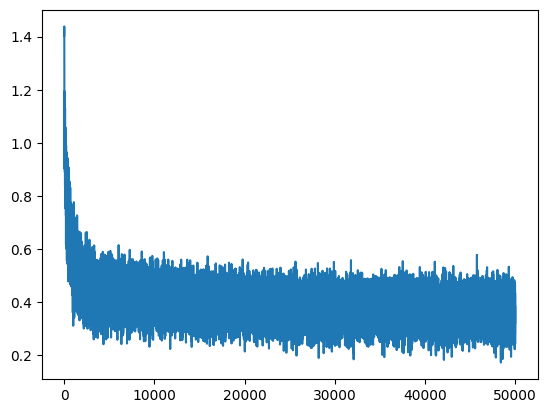

In [38]:
plt.plot(stepi, lossi)

In [39]:
print(loss.item())

2.4135725498199463


In [40]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30)@W1+b1)
logits = h@W2+b2 
loss = F.cross_entropy(logits, Ytr)
loss 

tensor(2.3431, grad_fn=<NllLossBackward0>)

In [41]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30)@W1+b1)
logits = h@W2+b2 
loss = F.cross_entropy(logits, Ydev)
loss 

tensor(2.3664, grad_fn=<NllLossBackward0>)

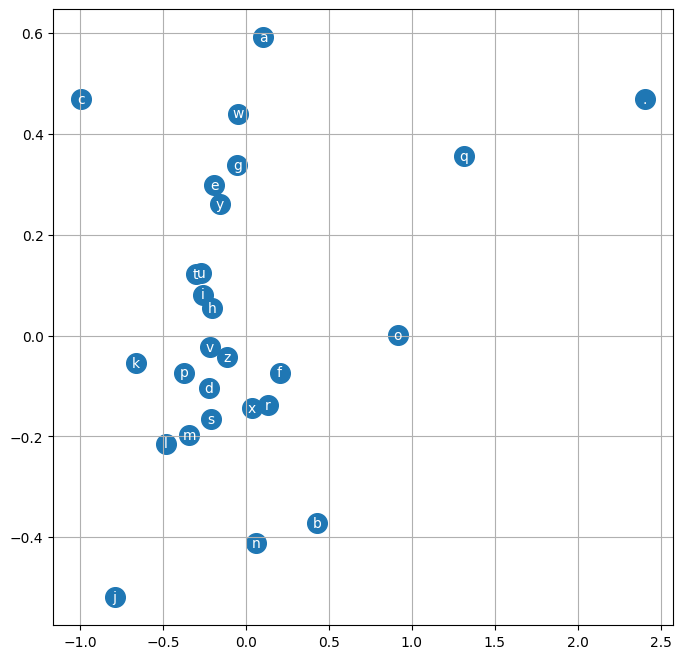

In [42]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), itos[i],ha="center",va="center", color="white")
plt.grid('minor')

In [43]:
logits.max(1)

torch.return_types.max(
values=tensor([0.2487, 2.6034, 2.7013,  ..., 5.0869, 8.6623, 9.0817],
       grad_fn=<MaxBackward0>),
indices=tensor([ 3, 14,  1,  ..., 12,  1, 14]))

In [44]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [45]:
#training split, dev/validation split, test split 
#80%, 10%, 10%

In [46]:
#sampling from the model

g = torch.Generator().manual_seed(2147483647) 

for _ in range(20):

    out = []
    context = [0]*block_size #initialize with all ...
    while True:
        emb = C[torch.tensor([context])] #(1,block_size,d)
        h = torch.tanh(emb.view(1,-1)@ W1 + b1)
        logits = h@W2 + b2 
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0 :
            break 

    print(''.join(itos[i] for i in out))


munide.
caralaz.
prelyn.
ember.
shin.
toldo.
marel.
brannaanvandleelailabduilee.
mel.
sery.
cayla.
terindellesta.
demmernona.
lena.
jazlyn.
calyne.
maran.
jamilynn.
moul.
wynil.
